# OPAS Twitter Analysis

In [1]:
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import json
import re
!pip install unidecode
import unidecode
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 24.7 MB/s 


In [2]:
entity = 'opas'
agency_twitter = 'OPASOMSBrasil'

In [3]:
# setup security 
access_token = '1006599768104144896-08Q8MuqehWAXLYxH4qfQPd3ihda2WW'
access_token_secret = 'hZGfKdUzY1t2jUrA5t2egNhoKTPCz457orKvFVVDD117G'
consumer_key = 'mVDo4ha0iWDHYXdalHH6g8tx7'
consumer_secret = 'A6vRmL8VmLwpncQD2at0PHkzBswjT7m70BWmpv0rMkxBbvIoan'

In [4]:
# setup file store
from google.colab import drive
drive.mount('/content/drive/')
path_drive = '/content/drive/My Drive/[UFU] Pesquisa/MobiSocial 2022/'
file = path_drive + entity + '/' + entity + '_tweets.json'
edges_file = path_drive + entity + '/' + entity + '_hashtags.csv'

Mounted at /content/drive/


# Getting tweets

In [ ]:
import tweepy #https://github.com/tweepy/tweepy
import csv

def get_all_tweets(screen_name, filew):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    alltweets = []

    new_tweets = api.user_timeline(screen_name = screen_name,count=200,tweet_mode='extended')

    for tweet in new_tweets:
        json_str = json.dumps(tweet._json)
        filew.write(json_str + '\n')
    
    alltweets.extend(new_tweets)

    oldest = alltweets[-1].id - 1

    while len(new_tweets) > 0:
        print ("getting tweets before %s" % (oldest))

        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest,tweet_mode='extended')

        for tweet in new_tweets:
            json_str = json.dumps(tweet._json)
            filew.write(json_str + '\n')
        
        alltweets.extend(new_tweets)

        oldest = alltweets[-1].id - 1

        print ("...%s tweets downloaded so far" % (len(alltweets)))
        
filew = open(file, 'w')
get_all_tweets(agency_twitter, filew)
filew.close()


getting tweets before 1491452305245294594
...400 tweets downloaded so far
getting tweets before 1476553660981075974
...600 tweets downloaded so far
getting tweets before 1461002950227148807
...800 tweets downloaded so far
getting tweets before 1450840805917265921
...1000 tweets downloaded so far
getting tweets before 1438161962744127487
...1200 tweets downloaded so far
getting tweets before 1428019666895753219
...1400 tweets downloaded so far
getting tweets before 1417880959282712587
...1600 tweets downloaded so far
getting tweets before 1408442491502747655
...1800 tweets downloaded so far
getting tweets before 1395039015804485636
...2000 tweets downloaded so far
getting tweets before 1385303270483275777
...2200 tweets downloaded so far
getting tweets before 1375430466631766020
...2400 tweets downloaded so far
getting tweets before 1364685975448879107
...2600 tweets downloaded so far
getting tweets before 1354512568510013444
...2800 tweets downloaded so far
getting tweets before 133418

## Hashtags network

In [ ]:
with open(file, 'r') as f:
    alltweets = f.readlines()

texts = []
for tweet_line in alltweets:   
    tweet = json.loads(tweet_line)
    texts.append(tweet['full_text'])

print(len(texts))

3225


In [ ]:
## get hashtags
def extract_hash_tags(s):
    return set(part[1:] for part in s.split() if part.startswith('#'))

def normalize_text(s):
    s = re.sub(r'[^\w\s]','',s)
    s = s.lower()
    s = unidecode.unidecode(s)
    return s

allhashtags = set()
hashtagsList = []
for i, text in enumerate(texts):
    wordList = extract_hash_tags(text)
    if wordList:
        hashtags = [normalize_text(w) for w in wordList]
        for w in hashtags:
            allhashtags.add(w)
        print(i, wordList, hashtags)
        hashtagsList.append(hashtags)

print('\n### Tamanho total do conjunto de hashtags:', len(allhashtags))
print('\n### Quantidade de listas de hashtags:', len(hashtagsList))

0 {'DIM2022', '8M'} ['dim2022', '8m']
1 {'ResistênciaAntimicrobiana'} ['resistenciaantimicrobiana']
4 {'COVID19'} ['covid19']
5 {'Primeiros28Dias', 'SaúdeDoRecémNascido'} ['primeiros28dias', 'saudedorecemnascido']
6 {'COVID19!'} ['covid19']
9 {'Primeiros28Dias', 'SaúdeDoRecémNascido'} ['primeiros28dias', 'saudedorecemnascido']
11 {'EIOS'} ['eios']
12 {'COVID19', 'tuberculose.'} ['covid19', 'tuberculose']
13 {'DiaMundialDaTB', 'tuberculose'} ['diamundialdatb', 'tuberculose']
14 {'TB,'} ['tb']
15 {'tuberculose', 'HIV', 'DiaMundialDaTB.', 'ResistênciaAntimicrobiana.'} ['tuberculose', 'hiv', 'diamundialdatb', 'resistenciaantimicrobiana']
16 {'COVID19'} ['covid19']
17 {'COVID19'} ['covid19']
18 {'AindaNãoAcabou', 'COVID19'} ['aindanaoacabou', 'covid19']
21 {'DIM2022'} ['dim2022']
22 {'Ômicron', 'COVID19'} ['omicron', 'covid19']
23 {'SemanaDoSal', 'MaisSaborMenosSal', 'MenosSal'} ['semanadosal', 'maissabormenossal', 'menossal']
24 {'SemanaDoSal', 'MaisSaborMenosSal', 'MenosSal', 'hipertensão

In [ ]:
## normalizing hashtaghs
def normalize(hashtag):
    if hashtag == 'COVID19': return 'covid19'
    return hashtag
  

for hashtags in hashtagsList:
    for i in range(len(hashtags)):
        hashtags[i] = normalize(hashtags[i])

In [ ]:
## building the network
edges = {}
for hashtags in hashtagsList:
    for i in range(len(hashtags)):
        for j in range(i+1, len(hashtags)):
            key = hashtags[i] + '-' + hashtags[j]
            edge = (hashtags[i], hashtags[j], 1)
            if key in edges:
                (h1, h2, w) = edges[key]
                edge = (h1, h2, w+1)
                edges.update( {key : edge} )
            else:
                edges.update( {key : edge} )
            print(edge)

('dim2022', '8m', 1)
('primeiros28dias', 'saudedorecemnascido', 1)
('primeiros28dias', 'saudedorecemnascido', 2)
('covid19', 'tuberculose', 1)
('diamundialdatb', 'tuberculose', 1)
('tuberculose', 'hiv', 1)
('tuberculose', 'diamundialdatb', 1)
('tuberculose', 'resistenciaantimicrobiana', 1)
('hiv', 'diamundialdatb', 1)
('hiv', 'resistenciaantimicrobiana', 1)
('diamundialdatb', 'resistenciaantimicrobiana', 1)
('aindanaoacabou', 'covid19', 1)
('omicron', 'covid19', 1)
('semanadosal', 'maissabormenossal', 1)
('semanadosal', 'menossal', 1)
('maissabormenossal', 'menossal', 1)
('semanadosal', 'maissabormenossal', 2)
('semanadosal', 'menossal', 2)
('semanadosal', 'hipertensao', 1)
('maissabormenossal', 'menossal', 2)
('maissabormenossal', 'hipertensao', 1)
('menossal', 'hipertensao', 1)
('semanadosal', 'maissabormenossal', 3)
('semanadosal', 'menossal', 3)
('maissabormenossal', 'menossal', 3)
('maissabormenossal', 'menossal', 4)
('maissabormenossal', 'menossalou', 1)
('menossal', 'menossalou'

In [ ]:
## generating edges file
filew = open(edges_file, 'w')
filew.write('Source,Target,weight\n')
print('Source,Target,weight')
for key, edge in edges.items():
    (h1,h2,w) = edge
    if h1 and h2:
        edgeLine = h1 + ',' + h2 + ',' + str(w)
        print(edgeLine)
        filew.write(edgeLine + '\n')
        
filew.close()    

Source,Target,weight
dim2022,8m,3
primeiros28dias,saudedorecemnascido,19
covid19,tuberculose,1
diamundialdatb,tuberculose,1
tuberculose,hiv,1
tuberculose,diamundialdatb,1
tuberculose,resistenciaantimicrobiana,1
hiv,diamundialdatb,1
hiv,resistenciaantimicrobiana,1
diamundialdatb,resistenciaantimicrobiana,1
aindanaoacabou,covid19,7
omicron,covid19,11
semanadosal,maissabormenossal,3
semanadosal,menossal,3
maissabormenossal,menossal,7
semanadosal,hipertensao,1
maissabormenossal,hipertensao,2
menossal,hipertensao,2
maissabormenossal,menossalou,1
menossal,menossalou,1
cureallamericas,cancerinfantil,4
8m,diainternacionaldamulher,2
8m,covid19,1
diainternacionaldamulher,covid19,2
variantescovid19,covid19,5
alcool,vivamelhorbebamenos,3
hipertensao,heartsamericas,8
hipertensao,pressaoarterial,4
heartsamericas,pressaoarterial,2
caribe,covid19,1
diabetes,ifnotnowwhen,2
covax,covid19,59
cancerinfantil,cureallamericas,3
acttogheter,clubworldcup,1
acttogheter,covid19,1
clubworldcup,covid19,2
facatudo,

# Engagement analysis

In [5]:
with open(file, 'r') as f:
    alltweets = f.readlines()

texts = []
for tweet_line in alltweets:   
    tweet = json.loads(tweet_line)
    engaged = tweet['retweet_count'] + tweet['favorite_count'] + len(tweet['entities']['user_mentions'])
    texts.append([tweet['id_str'],tweet['created_at'],tweet['retweet_count'],tweet['favorite_count'],len(tweet['entities']['user_mentions']),tweet['is_quote_status'],engaged,tweet['full_text']])

columns = ['id','created_at','rt_count','fav_count','mentions_count','is_quote','engaged','text']
df = pd.DataFrame(texts, columns=columns)
total_tweets = len(df)
print('Total tweets: ', total_tweets)

df.head()

Total tweets:  3225


,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text
0,1509606460006797315,Thu Mar 31 19:00:01 +0000 2022,2,3,0,False,5,"🌎🌍🌏 Você sabia que, no mundo, a maioria do trabalho de cuidado não remunerado é feito por mulheres e meninas de grupos desfavorecidos socialmente? 👩🏽‍👩🏾👩🏿👧🏽 \n\nSaiba mais ⬇️ \nhttps://t.co/J1gWMSSTuv \n\n#DIM2022 #8M https://t.co/sHHHn47cSl"
1,1509530962937335810,Thu Mar 31 14:00:01 +0000 2022,2,1,0,False,3,"👋 Os antibióticos são os antimicrobianos mais utilizados. Seu uso excessivo gera resistência, o que coloca em risco a cura de várias doenças 💊👩🏻‍🦰👨🏻‍🦱👵🏿👴 #ResistênciaAntimicrobiana\n\n+INFO ⇨ https://t.co/6MwvarrfR4 https://t.co/ZHJynQzNMH"
2,1509244071839076352,Wed Mar 30 19:00:01 +0000 2022,2,5,0,False,7,A OMS lançou hoje as primeiras diretrizes globais para apoiar mulheres e recém-nascidos 🤱 no período pós-natal – as primeiras 6️⃣ semanas após o nascimento. Este é um momento crucial para garantir a sobrevivência do bebê e da mãe.\n\nMais info 👇🏿\n\nhttps://t.co/2i1kdCsj6N
3,1509165687868211206,Wed Mar 30 13:48:33 +0000 2022,2,2,0,False,4,https://t.co/3xNe1ux4N8
4,1509165614765641734,Wed Mar 30 13:48:16 +0000 2022,1,5,0,False,6,"Você está c/ #COVID19 ou cuidando 🧡 de alguém infectado 🦠? Se observar sintomas como falta de ar, confusão, perda de fala e dor no peito, busque imediatamente uma unidade de saúde.\n\nConfira outras recomendações a seguir ⬇ ⬇\n\nLembre-se: lave as 👐🏽 c/ 💦 e 🧼 frequentemente. https://t.co/YqQhZj75oM"


In [6]:
## counting number of engaged tweets
def engaged_tweets(df):
    #return df[(df.rt_count > 0) | (df.fav_count > 0)].count()
    return df[(df.engaged > 0)].count()

def not_engaged_tweets(df):
    return df[(df.engaged == 0)].count()

def engaged_rt_tweets(df):
    return df[(df.rt_count > 0)].count()

def engaged_fav_tweets(df):
    return df[(df.fav_count > 0)].count()

def engaged_mention_tweets(df):
    return df[(df.mentions_count > 0)].count()

sum_engaged_tweets = engaged_tweets(df)
print('Engaged tweets: ', sum_engaged_tweets['rt_count'], sum_engaged_tweets['rt_count']*100/total_tweets)
sum_engaged_rt_tweets = engaged_rt_tweets(df)
print('Engaged rt tweets: ', sum_engaged_rt_tweets['rt_count'], sum_engaged_rt_tweets['rt_count']*100/sum_engaged_tweets['rt_count'])
sum_engaged_fav_tweets = engaged_fav_tweets(df)
print('Engaged fav tweets: ', sum_engaged_fav_tweets['fav_count'], sum_engaged_fav_tweets['fav_count']*100/sum_engaged_tweets['fav_count'])
sum_engaged_mention_tweets = engaged_mention_tweets(df)
print('Engaged mention tweets: ', sum_engaged_mention_tweets['mentions_count'], sum_engaged_mention_tweets['mentions_count']*100/sum_engaged_tweets['mentions_count'])
sum_not_engaged_tweets = not_engaged_tweets(df)
print('Not Engaged tweets: ', sum_not_engaged_tweets['rt_count'], sum_not_engaged_tweets['rt_count']*100/total_tweets)

Engaged tweets:  3213 99.62790697674419
Engaged rt tweets:  2210 68.78306878306879
Engaged fav tweets:  3042 94.67787114845939
Engaged mention tweets:  2110 65.67071272953626
Not Engaged tweets:  12 0.37209302325581395


In [7]:
## getting most engaged tweets

df = df.sort_values(by=['engaged'],ascending=False)
df.head(10)

,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text
461,1466132380658376706,Wed Dec 01 19:49:33 +0000 2021,471,2636,0,False,3107,A Ômicron foi classificada como variante de preocupação do vírus SARS-CoV-2.\n\n🔴 Pesquisas e análises laboratoriais estão sendo conduzidas para entender o impacto da Ômicron na saúde pública.\n\n✅ Não baixe a guarda. Siga todas as precauções.\n\n#VariantesCOVID19 https://t.co/P1L8UAbmcS
1936,1389202265748217858,Mon May 03 12:56:44 +0000 2021,541,2508,0,False,3049,🤔 Você sabe como as vacinas 💉 funcionam em nosso organismo? 👇🏿 https://t.co/d2LiZjDPaw
1941,1388475325227618307,Sat May 01 12:48:08 +0000 2021,145,1147,0,False,1292,"O Brasil 🇧🇷 receberá, entre hoje e amanhã, 3.981.600 doses de vacinas 💉 contra #COVID19 por meio do Mecanismo COVAX, um esforço global que envolve CEPI, Gavi, OMS, UNICEF e OPAS. https://t.co/gFnZ1D2FVo"
342,1486036149005012992,Tue Jan 25 18:00:01 +0000 2022,193,797,0,False,990,"Em várias partes do mundo, vemos uma “pandemia de não vacinados” ou “vacinados com esquema incompleto”.\n\nNão espere ficar na UTI ou contaminar outras pessoas p/ entender a importância da vacinação. A vacina ajudará a proteger você e seus entes queridos.\n\n#COVID19 #AindaNãoAcabou https://t.co/xarTLQQxiL"
1431,1416457677324963841,Sat Jul 17 18:00:01 +0000 2021,172,740,0,False,912,🧐 Como as vacinas 💉 funcionam no nosso corpo? \n\nClique no play ▶️ para saber mais❗️ https://t.co/BZ6yHMliEw
2099,1380221215441305601,Thu Apr 08 18:09:15 +0000 2021,91,622,0,False,713,Uma nova pesquisa de instituições brasileiras 🇧🇷 feita no estado do Amazonas com apoio da OPAS apontou que a vacina CoronaVac é efetiva contra a variante da #COVID19 denominada P.1 (também conhecida como B.1.1.28.1) 👉 https://t.co/GRnKd8i7cT\n\n📸 Zambranas/OPAS/OMS
357,1483574930763567110,Tue Jan 18 23:00:01 +0000 2022,110,554,0,False,664,"Tomou a vacina contra #COVID19 e passou mal depois? Não tenha medo, esses eventos adversos costumam ser leves e durar pouco tempo. Já as complicações causadas pela doença podem ser muito piores🤒 e deixar sequelas para a vida inteira. Portanto, vacina no braço! 💪 #AindaNãoAcabou https://t.co/ccdfDXKurT"
1021,1437861205582893056,Tue Sep 14 19:30:00 +0000 2021,84,510,0,False,594,"Há muitas pessoas sofrendo 😔 durante a pandemia de #COVID19 🦠. É normal e compreensível se sentir ansioso(a), triste ou estressado(a) neste momento 💛. Se você precisar, peça ajuda. 👩‍⚕️ \n\n#PrevençãoaoSuicídio #WSPD2021 https://t.co/QvvRJ90Lne"
2260,1372207757651288064,Wed Mar 17 15:26:38 +0000 2021,180,384,1,False,565,"Mesmo as pessoas vacinadas devem continuar praticando o distanciamento social, usando máscaras e evitando grandes aglomerações - @DirOPSPAHO"
512,1464236764139302915,Fri Nov 26 14:17:03 +0000 2021,94,457,0,False,551,As vacinas 💉 são uma ferramenta muito poderosa 💪🏿 em nossa luta contra #COVID19. \n\nEfeitos secundários graves são muito raros. Saiba que o risco de reações adversas graves às vacinas é muito menor que o risco de doença grave ou morte por COVID-19.\n\n#VacineSe https://t.co/ClKDH9Ibk2


In [8]:
## getting collect period
pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y").sort_values()

3224   2020-09-28 14:26:52
3223   2020-09-28 14:29:01
3222   2020-09-28 14:30:19
3221   2020-09-28 14:32:14
3220   2020-09-28 14:33:52
               ...        
4      2022-03-30 13:48:16
3      2022-03-30 13:48:33
2      2022-03-30 19:00:01
1      2022-03-31 14:00:01
0      2022-03-31 19:00:01
Name: created_at, Length: 3225, dtype: datetime64[ns]

In [9]:
## most mentioned users
with open(file, 'r') as f:
    alltweets = f.readlines()

mentions = {}
for tweet_line in alltweets:   
    tweet = json.loads(tweet_line)
    user_mentions = tweet['entities']['user_mentions']
    for user in user_mentions:
        key = user['screen_name']
        if key in mentions:
            count = mentions[key]
            mentions.update( {key : count+1} )
        else:
            mentions.update( {key : 1} )
        
for w in sorted(mentions, key=mentions.get, reverse=True):
    print(w, mentions[w])


DirOPSPAHO 1760
Jarbas_Barbosa 223
minsaude 34
TwitterBrasil 16
actbr 8
WHO 7
AMB_oficial 7
bireme 5
OPASOMSBrasil 5
FAOBrasil 5
NacoesUnidas 4
Mapa_Brasil 4
UEnoBrasil 4
OIEAnimalHealth 4
panaftosa_inf 3
Cofen_oficial 3
opsoms 3
fiocruz 3
Funasa 3
anahpbrasil 3
rpsp_pajph 3
ONUBrasil 3
UNICEF 2
FIFAcom 2
ChelseaFC 2
Palmeiras 2
tchulim 2
ConassOficial 2
unicefbrasil 2
campusvirtualsp 2
free_equal 2
butantanoficial 2
Alissonbecker 2
COVID19 2
AmazonasGoverno 2
UNAIDSBrasil 2
CesarAzpi 1
alexandrismos 1
spartakus 1
fiotecfiocruz 1
OEA_BR 1
Twitter 1
ONUNews 1
pahowho 1
AliancaAlimenta 1
endocrinologia 1
_abeso 1
ifmsabrazil 1
iecsarg 1
UFPel 1
ForumDCNTs 1
Icict_Fiocruz 1
UNVBrasil 1
CEPIvaccines 1
gavi 1
VitalStrat 1
secsaudedf 1
NutriNetBrasil 1
fiocruzbrasilia 1
DrTedros 1
mqueiroga2 1
mhpss 1
fabiosilvagomes 1
IncubatorGHAI 1
pinkfong_usa 1
TigresOficial 1
BloombergDotOrg 1
PrefManaus 1
DiegoMe76210737 1
Prefeitura_Rio 1
Saude_Rio 1
embrapa 1
unifesp 1
FAO 1
FAOBrasilCoop 1
Sesau_Ro

# Temporal Analysis

In [10]:
total = len(df)
print('Total number of tweets: ', total)

Total number of tweets:  3225


Text(0.5, 1.0, 'opas tweets distribution per month')

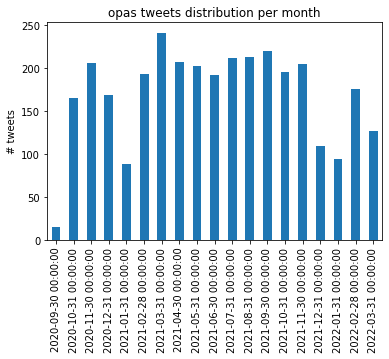

In [11]:
## temporal analysis
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="M"))
g['id'].count().plot(kind="bar")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' tweets distribution per month')

Text(0.5, 1.0, 'opas tweets distribution per week')

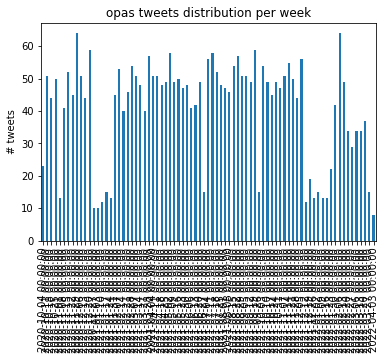

In [12]:
## temporal analysis
import numpy
%matplotlib inline

df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="W"))
g['id'].count().plot(kind="bar")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' tweets distribution per week')

Text(0.5, 1.0, 'opas number of tweets per day')

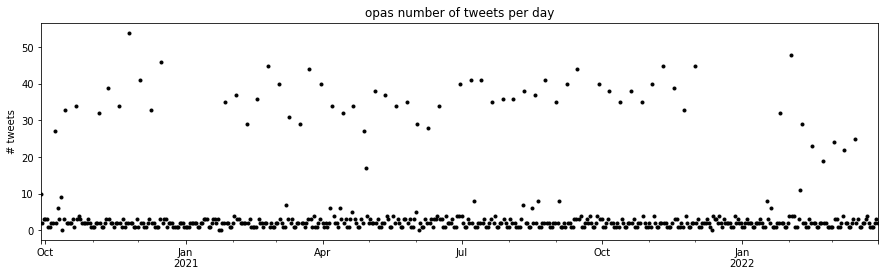

In [13]:
## temporal analysis
import numpy
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
g['id'].count().plot(style="k.")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' number of tweets per day')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Figure size 1080x288 with 0 Axes>

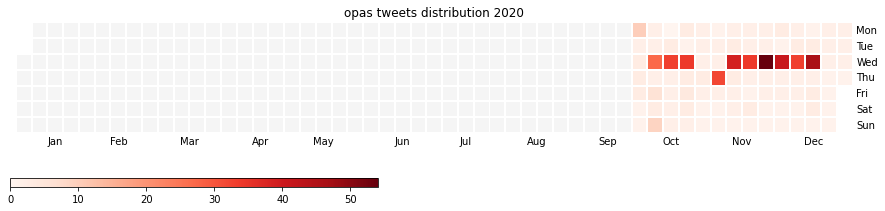

In [14]:
## temporal analysis
import numpy
!pip install calmap
import calmap
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
quantities = g['id'].count()

year = 2020
fig = plt.figure(figsize=(15,6))
plt.title(entity + ' tweets distribution ' + str(year))
#ax = fig.add_subplot(111)
cax = calmap.yearplot(quantities, year=year)
#fig.colorbar(cax.get_children()[1], ax=cax, orientation='vertical', aspect=2)

cbar_ax = fig.add_axes([0.12, 0.25, 0.34, 0.02])
fig.colorbar(cax.get_children()[1], cax=cbar_ax, orientation="horizontal")

<Figure size 1080x288 with 0 Axes>

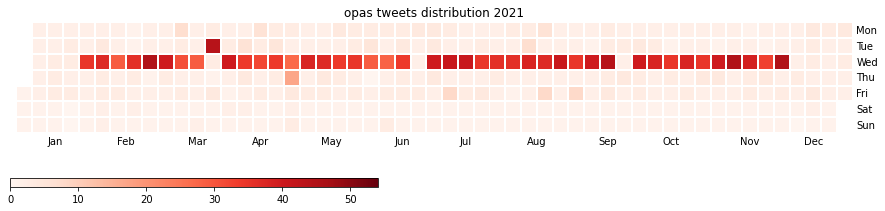

In [15]:
## temporal analysis
import numpy
#!pip install calmap
import calmap
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
quantities = g['id'].count()

year = 2021
fig = plt.figure(figsize=(15,6))
plt.title(entity + ' tweets distribution ' + str(year))
#ax = fig.add_subplot(111)
cax = calmap.yearplot(quantities, year=year)
#fig.colorbar(cax.get_children()[1], ax=cax, orientation='vertical', aspect=2)

cbar_ax = fig.add_axes([0.12, 0.25, 0.34, 0.02])
fig.colorbar(cax.get_children()[1], cax=cbar_ax, orientation="horizontal")

<Figure size 1080x288 with 0 Axes>

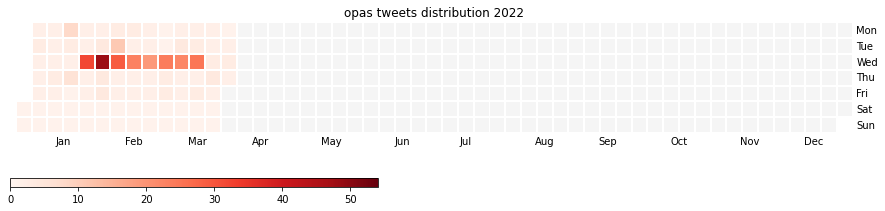

In [16]:
## temporal analysis
import numpy
#!pip install calmap
import calmap
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
quantities = g['id'].count()

year = 2022
fig = plt.figure(figsize=(15,6))
plt.title(entity + ' tweets distribution ' + str(year))
#ax = fig.add_subplot(111)
cax = calmap.yearplot(quantities, year=year)
#fig.colorbar(cax.get_children()[1], ax=cax, orientation='vertical', aspect=2)

cbar_ax = fig.add_axes([0.12, 0.25, 0.34, 0.02])
fig.colorbar(cax.get_children()[1], cax=cbar_ax, orientation="horizontal")

Text(0.5, 1.0, 'opas tweets distribution per hour')

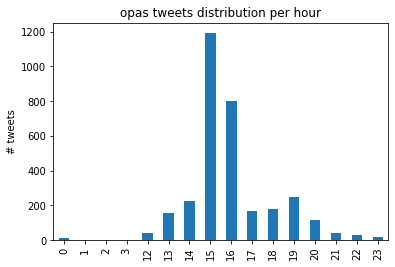

In [17]:
df.groupby(df['date'].dt.hour)['id'].count().plot(kind="bar")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' tweets distribution per hour')

# Trending analysis

In [18]:
import datetime
baseline_str = '2020-09-28'
baseline_date = datetime.datetime.strptime(baseline_str, '%Y-%m-%d')
baseline_date = baseline_date.date()
df['just_date'] = df['date'].apply(datetime.datetime.date)
baseline = df[df['just_date'] == baseline_date]
baseline_count = 0
if len(baseline) > 0:
    baseline_count = baseline.groupby('just_date').count()['id'][0]
print(baseline_count)

10


In [19]:
import math

def change_function(count):
    if math.isnan(count):
        count = 0
    if count == baseline_count:
        return 0
    change = 100*(count-baseline_count)/baseline_count
    return change

df_grouped = df.groupby('just_date', as_index=False).count()
df_grouped['change'] = df_grouped['date'].apply(change_function)
df_grouped.head(5)

,just_date,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text,date,change
0,2020-09-28,10,10,10,10,10,10,10,10,10,0.0
1,2020-09-29,2,2,2,2,2,2,2,2,2,-80.0
2,2020-09-30,3,3,3,3,3,3,3,3,3,-70.0
3,2020-10-01,3,3,3,3,3,3,3,3,3,-70.0
4,2020-10-02,3,3,3,3,3,3,3,3,3,-70.0


In [20]:
import datetime as dt
# generate pandas with reference_date from 2020-09-28 to 2022-02-01
start = datetime.datetime.strptime("28-09-2020", "%d-%m-%Y")
end = datetime.datetime.strptime("01-02-2022", "%d-%m-%Y")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

agencies_df = pd.DataFrame()
agencies_df['date_created'] = date_generated
agencies_df['date_created'] = agencies_df['date_created'].map(lambda x: x.date())
print(len(agencies_df))
agencies_df.head()

491


,date_created
0,2020-09-28
1,2020-09-29
2,2020-09-30
3,2020-10-01
4,2020-10-02


In [21]:
agencies_df = pd.merge(agencies_df, df_grouped, how='left', left_on='date_created', right_on='just_date')
agencies_df['change'] = agencies_df['date'].apply(change_function)
agencies_df = agencies_df.sort_values(by='date_created')
agencies_df['order'] = range(1, 1+len(agencies_df))
agencies_df.head()

,date_created,just_date,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text,date,change,order
0,2020-09-28,2020-09-28,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1
1,2020-09-29,2020-09-29,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-80.0,2
2,2020-09-30,2020-09-30,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-70.0,3
3,2020-10-01,2020-10-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-70.0,4
4,2020-10-02,2020-10-02,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-70.0,5


In [22]:
agencies_df.tail(42)

,date_created,just_date,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text,date,change,order
449,2021-12-21,2021-12-21,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-80.0,450
450,2021-12-22,2021-12-22,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-80.0,451
451,2021-12-23,2021-12-23,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-80.0,452
452,2021-12-24,2021-12-24,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-80.0,453
453,2021-12-25,2021-12-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-90.0,454
454,2021-12-26,2021-12-26,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-90.0,455
455,2021-12-27,2021-12-27,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,-60.0,456
456,2021-12-28,2021-12-28,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-80.0,457
457,2021-12-29,2021-12-29,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-70.0,458
458,2021-12-30,2021-12-30,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-80.0,459


<Figure size 1080x720 with 0 Axes>

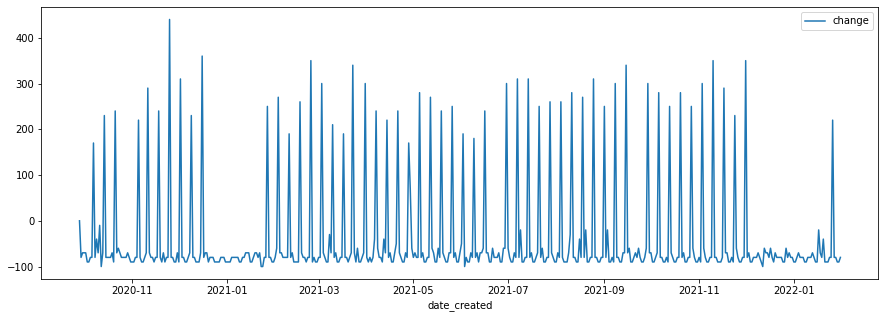

In [23]:
plt.figure(figsize=(15,10))
agencies_df.plot(kind='line', x='date_created', y='change',figsize=(15, 5))
plt.show()

In [49]:
#mark_firstcase = agencies_df[agencies_df['date_created']==datetime.date(2020,2,26)]['order'].to_list()[0]
#mark_firstmh = agencies_df[agencies_df['date_created']==datetime.date(2020,4,16)]['order'].to_list()[0]
#mark_secondmh = agencies_df[agencies_df['date_created']==datetime.date(2020,5,15)]['order'].to_list()[0]
#mark_thirdmh = agencies_df[agencies_df['date_created']==datetime.date(2020,6,2)]['order'].to_list()[0]

mark_firstvaccine = agencies_df[agencies_df['date_created']==datetime.date(2020,12,2)]['order'].to_list()[0]
mark_gamma = agencies_df[agencies_df['date_created']==datetime.date(2021,1,6)]['order'].to_list()[0]

mark_brazilvaccine = agencies_df[agencies_df['date_created']==datetime.date(2021,1,17)]['order'].to_list()[0]
mark_fourthmh = agencies_df[agencies_df['date_created']==datetime.date(2021,3,23)]['order'].to_list()[0]
mark_deadliest = agencies_df[agencies_df['date_created']==datetime.date(2021,3,29)]['order'].to_list()[0]
mark_cpi = agencies_df[agencies_df['date_created']==datetime.date(2021,4,27)]['order'].to_list()[0]
mark_omicron = agencies_df[agencies_df['date_created']==datetime.date(2021,11,26)]['order'].to_list()[0]
mark_topcases = agencies_df[agencies_df['date_created']==datetime.date(2022,1,27)]['order'].to_list()[0]

list_marks = [#mark_firstcase, mark_firstmh, mark_secondmh, mark_thirdmh, 
              mark_firstvaccine, mark_gamma,
              mark_brazilvaccine, mark_fourthmh, mark_deadliest, mark_cpi, mark_omicron, mark_topcases]
list_labels = [#'1stBraCase', '1stMH', '2ndMH', '3rdMH', 
               '1stVac', 'GAMMA', '1stBraVac', '4thMH', 'BraDeadliest', 'PCI', 'Omicron', 'BraTopCases']
list_marks

[66, 101, 112, 177, 183, 212, 425, 487]

[-100.    0.  100.  200.  300.  400.  500.  600.]
<a list of 8 Text major ticklabel objects>


Text(0.5, -0.2, 'PAHO')

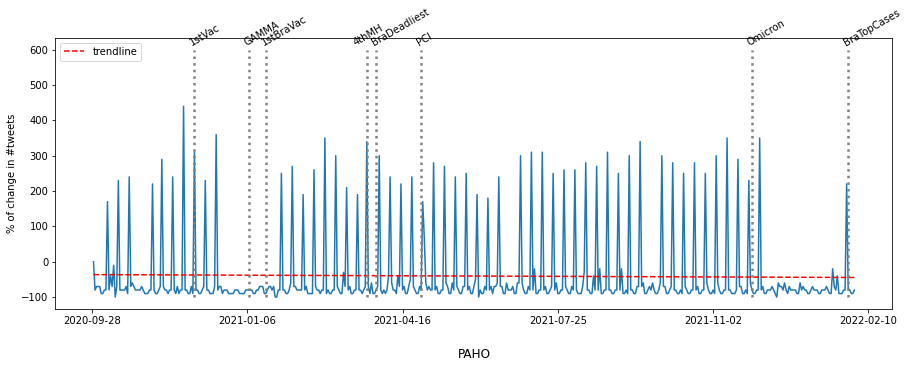

In [50]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def adjust_xticks(value):
    if value < 0:
      return ''
    start_date = agencies_df[agencies_df['order']==1]['date_created'][0]
    end_date = start_date + datetime.timedelta(days=value)
    label = str(end_date)
    return label

fig, ax = plt.subplots(figsize=(15,5))

# changes
x = agencies_df['order'].to_numpy()
y = agencies_df['change'].to_numpy()
x_new = np.linspace(x.min(), x.max(),len(agencies_df))
f = interp1d(x, y, kind='quadratic')
y_smooth=f(x_new)
ax.plot (x_new,y_smooth)
ax.set_ylabel('% of change in #tweets')

locs, labels = plt.xticks()
print(locs)
print(labels)
ax.set_xticklabels(np.array(list(map(adjust_xticks, locs))))


# baseline
#x_baseline = x
#y_baseline = [0]*len(x)
#line2 = ax.plot(x_baseline, y_baseline, '--', linewidth=0.5,
#                 label='baseline')

# trendline
z = np.polyfit(x.flatten(), y.flatten(), 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--", linewidth=1.5, label='trendline')

# covidline
#x_covidline = [57]*len(y_smooth)
#y_covidline = y_smooth
#line4 = ax.plot(x_covidline, y_covidline, '--', linewidth=0.5,
#                 label='covidline')
#plt.scatter (x, y)

# marklines
lines = []
for i, mark in enumerate(list_marks):
  x_covidline = [mark]*700
  y_covidline = [i for i in range(-100,600)]
  #x_covidline = [mark]*len(y_smooth)
  #y_covidline = y_smooth
  line = ax.plot(x_covidline, y_covidline, linestyle=':', linewidth=2.5,
                 #label=list_labels[i], 
                 color='gray')
  
  if i in [3]:
    position_x = mark-10
    position_y = 610
  else:
    position_x = mark-4
    position_y = 610
  ax.annotate(list_labels[i], 
             (position_x, position_y), 
             color='black', rotation=30,
             size=10)
  
  lines.append(line)


ax.legend(loc='upper left',# bbox_to_anchor=(0.5, 1.15),
          ncol=1, fancybox=True)
plt.title('PAHO', y=-0.2)